In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


In [3]:
# Import system libraries
import os
import time
import shutil
from pathlib import Path
import random

# Import data handling tools
import cv2
import itertools
import numpy as np
import pandas as pd

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

# Import deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD, Adagrad, Adadelta, Nadam, AdamW
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,
    BatchNormalization, AveragePooling2D, Input, Concatenate,
    GlobalAveragePooling2D
)
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3, DenseNet201, Xception, MobileNet, MobileNetV2
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

# Additional tools
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Debug message
print('Modules loaded')


modules loaded
modules loaded


In [4]:
# Generate data paths with labels
data_dir = '/kaggle/input/travelnowdb/TravelNow/dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [6]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

tr_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

#tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2593 validated image filenames belonging to 16 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1797 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 329 validated image filenames belonging to 16 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 220 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 324 validated image filenames belonging to 16 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 225 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [7]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

In [8]:
def cm(mo):
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    print("model.predict_generator ----->")
    preds = mo.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    print(y_pred.shape)


    print("test_gen.class_indices ----->")
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

#     target_names = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation= 45)
#     plt.yticks(tick_marks, classes)


    # Classification report
    print("classification_report ----->")
    print(classification_report(test_gen.classes, y_pred, target_names= classes))

    print("plot_confusion_matrix 1 ----->")
    cm = confusion_matrix(test_gen.classes, y_pred)
    #plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
    target_names = ["Benign", "Malignant"]
    #df_cm = pd.DataFrame(cm, range(4), range(4))
    #df_cm = pd.DataFrame(cm, index=["Closed", "Open", "No Yawn", "Yawn"], columns=["Closed", "Open", "No Yawn", "Yawn"])
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(8,6))
    #sn.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, cmap="OrRd",fmt='g') # font size
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix")
    plt.savefig("Confusion_Matrix_1", dpi=300)
    plt.show()

<ipython-input-9-dee6df4d9b85>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 15/163 ━━━━━━━━━━━━━━━━━━━━ 1:16 515ms/step - accuracy: 0.0564 - loss: 2.8328

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


163/163 ━━━━━━━━━━━━━━━━━━━━ 172s 768ms/step - accuracy: 0.0646 - loss: 2.7895 - val_accuracy: 0.1003 - val_loss: 2.7414
Epoch 2/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 502ms/step - accuracy: 0.1101 - loss: 2.7073 - val_accuracy: 0.1702 - val_loss: 2.5417
Epoch 3/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 477ms/step - accuracy: 0.2152 - loss: 2.4875 - val_accuracy: 0.2401 - val_loss: 2.3797
Epoch 4/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 497ms/step - accuracy: 0.2595 - loss: 2.2272 - val_accuracy: 0.2675 - val_loss: 2.2485
Epoch 5/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 487ms/step - accuracy: 0.3193 - loss: 2.0490 - val_accuracy: 0.3374 - val_loss: 2.1698
Epoch 6/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 473ms/step - accuracy: 0.3648 - loss: 1.8506 - val_accuracy: 0.3465 - val_loss: 2.4805
Epoch 7/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 499ms/step - accuracy: 0.3903 - loss: 1.7724 - val_accuracy: 0.3283 - val_loss: 2.7481
Epoch 8/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 490ms/step - accuracy: 0.4356 - loss: 1.6571 - va

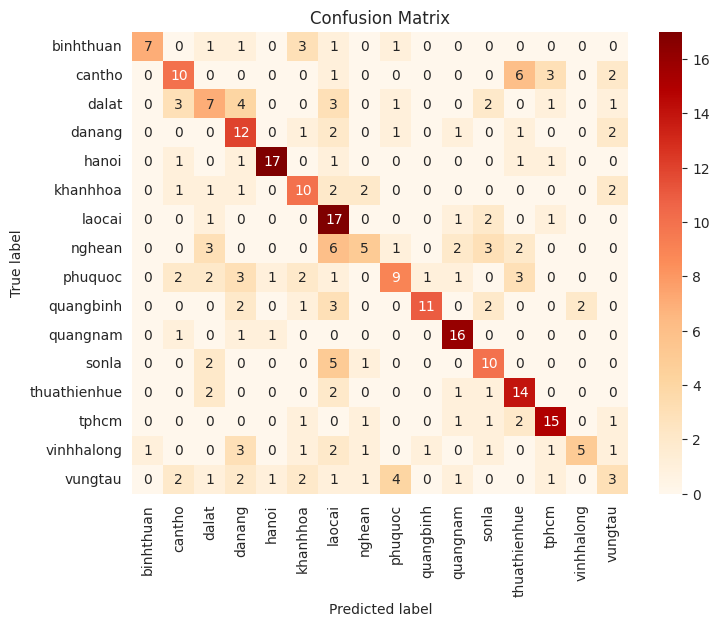

5/9 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.9504 - loss: 0.3062

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - accuracy: 0.9495 - loss: 0.2442
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - accuracy: 0.4984 - loss: 2.3399
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.5572 - loss: 2.4766
Train Loss:  0.17563043534755707
Train Accuracy:  0.9513888955116272
--------------------
Valid Loss:  2.5821406841278076
Valid Accuracy:  0.5347222089767456
--------------------
Test Loss:  2.6274118423461914
Test Accuracy:  0.5347222089767456


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model

# Khởi tạo baseModel
baseModel = tf.keras.applications.MobileNetV2(
    include_top=False,
    pooling="avg",
    weights="imagenet",
    input_tensor=Input(shape=(224, 224, 3))
)

# Unfreeze một số layer của base model và fine-tune tiếp
for layer in baseModel.layers[-20:]:  # Unfreeze 20 layer cuối
    layer.trainable = True

# Lấy output của layer conv cuối cùng (trong trường hợp này là output của baseModel)
x = baseModel.output

# Thêm các layer mới
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.35)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(150, activation='relu')(x)
x = Dense(180, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(class_count, activation='softmax')(x)

# Kết hợp baseModel và các layer mới
model = Model(inputs=baseModel.input, outputs=output)

batch_size = 16   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 35   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.97   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

# callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
#             factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


print("[INFO] training head...")
history = model.fit(x= train_gen, epochs= epochs,batch_size=batch_size,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)
print("done...")

cm(model)
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
#plot_training_2(history)

In [10]:
def plot_training_2(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    #Epochs = range(1, len(tr_acc)+1)
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'Best Epoch: {str(index_loss + 1)}'
    acc_label = f'Best Epoch: {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_acc, 'g', label= 'Training Accuracy', linewidth=2)
    plt.plot(Epochs, val_acc, 'r', label= 'Validation Accuracy', linewidth=2)
    plt.scatter(index_acc + 1 , acc_highest, s= 100, c= 'blue', label= acc_label)
    plt.title('Training / Validation Accuracy')
    plt.xlabel('Epochs')
    #plt.xticks(Epochs)
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.grid(False)
    ax = plt.gca()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_loss, 'g', label= 'Training Loss', linewidth=2)
    plt.plot(Epochs, val_loss, 'r', label= 'Validation Loss', linewidth=2)
    plt.scatter(index_loss + 1, val_lowest, s= 100, c= 'blue', label= loss_label)
    plt.title('Training / Validation Loss')
    plt.xlabel('Epochs')
    #plt.xticks(Epochs)
    plt.ylabel('Loss')
    plt.legend()
    #plt.grid(False)
    ax = plt.gca()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    

    plt.tight_layout
    plt.savefig("plot_training_2", dpi=300)

    plt.show()

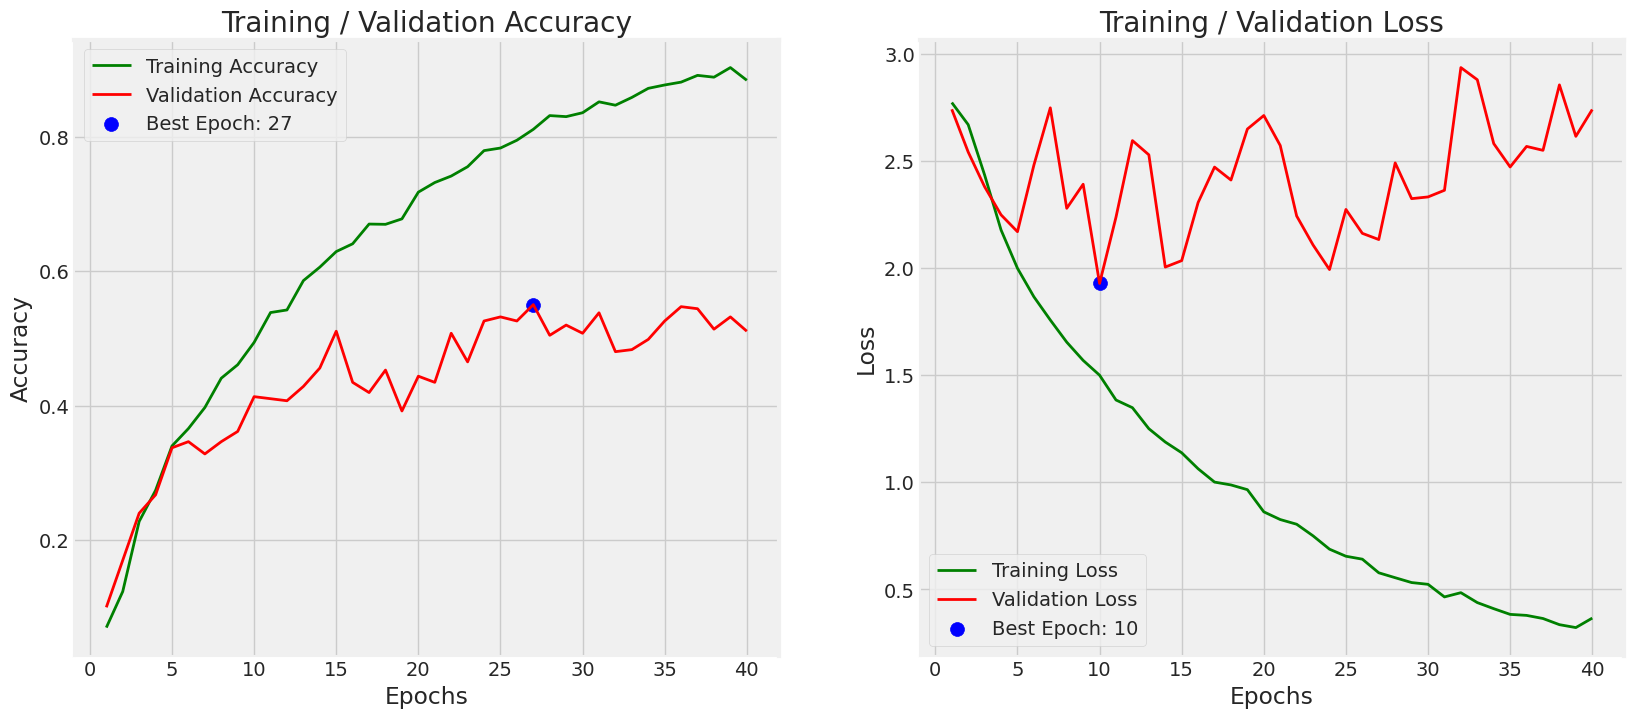

In [11]:
plot_training_2(history)

In [47]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import json
import os

# Lưu mô hình sau khi huấn luyện
def save_model(model, model_path, labels, label_path):
    # Lưu mô hình
    model.save(model_path)
    print(f"Model saved to {model_path}")
    
    # Lưu các class labels
    with open(label_path, "w") as f:
        json.dump(labels, f)
    print(f"Labels saved to {label_path}")

# Load mô hình đã lưu
def load_saved_model(model_path, label_path):
    # Load mô hình
    model = load_model(model_path)
    
    print(f"Model loaded from {model_path}")
    
    # Load labels
    with open(label_path, "r") as f:
        labels = json.load(f)
    print(f"Labels loaded from {label_path}")
    return model, labels

# Phân loại ảnh
def classify_image(model, image_path, target_size):
    # Load và tiền xử lý ảnh
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều batch
    #img_array = img_array / 255.0  # Chuẩn hóa (nếu mô hình yêu cầu)
    
    # Dự đoán
    predictions = model.predict(img_array)
    
    predicted_class = np.argmax(predictions, axis=1)[0]

    return predicted_class

# Hiển thị thông tin class được phân loại
def display_classification(class_label, classes):
    
    print(f"Image classified as: {classes[class_label]}")
    return classes[class_label]

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
classes

['binhthuan',
 'cantho',
 'dalat',
 'danang',
 'hanoi',
 'khanhhoa',
 'laocai',
 'nghean',
 'phuquoc',
 'quangbinh',
 'quangnam',
 'sonla',
 'thuathienhue',
 'tphcm',
 'vinhhalong',
 'vungtau']

In [14]:
model_path = "model.h5"
label_path = "labels.json"
save_model(model, model_path, classes, label_path)

Model saved to model.h5
Labels saved to labels.json


In [46]:
image_path = "/kaggle/input/travelnowdb/TravelNow/dataset/cantho/1.jpg"
target_size = (224, 224)
class_label = classify_image(model, image_path, target_size)
print(class_label)
display_classification(class_label, classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6
Image classified as: laocai
